In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
import sys

# # 한글 출력 인코딩 설정 (Windows)
# if sys.platform == 'win32':
#     import io
#     sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')
#     sys.stderr = io.TextIOWrapper(sys.stderr.buffer, encoding='utf-8')

# 설정
DATA_FILE = 'blackjack_probabilities_data.csv'  # 확률값이 이미 포함된 데이터
MODEL_SAVE_PATH = 'blackjack_model_probabilities.pth'
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
TEST_SIZE = 0.2
RANDOM_SEED = 42

# CUDA 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class BlackjackDataset(Dataset):
    """블랙잭 데이터셋 클래스"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [3]:
# 여러 모델 변형 정의

# 1. 기본 모델 (ReLU 사용)
class BlackjackModelBase(nn.Module):
    """기본 모델: 104 -> 256 -> 128 -> 64 -> 2 (ReLU)"""
    def __init__(self, input_size=104, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


# 2. 전부 Sigmoid 버전
class BlackjackModelSigmoid(nn.Module):
    """Sigmoid 모델: 104 -> 256 -> 128 -> 64 -> 2 (전부 Sigmoid)"""
    def __init__(self, input_size=104, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


# 3. 깊은 구조
class BlackjackModelDeep(nn.Module):
    """깊은 구조: 104 -> 512 -> 256 -> 128 -> 64 -> 2"""
    def __init__(self, input_size=104, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x


# 4. 얕은 구조
class BlackjackModelShallow(nn.Module):
    """얕은 구조: 104 -> 128 -> 64 -> 2"""
    def __init__(self, input_size=104, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


# 5. 넓은 구조
class BlackjackModelWide(nn.Module):
    """넓은 구조: 104 -> 512 -> 512 -> 2"""
    def __init__(self, input_size=104, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


# 6. 대안 구조
class BlackjackModelAlt(nn.Module):
    """대안 구조: 104 -> 256 -> 256 -> 128 -> 2"""
    def __init__(self, input_size=104, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


# 모델 설정 딕셔너리
MODEL_CONFIGS = {
    'base': {
        'name': '기본 모델 (ReLU)',
        'class': BlackjackModelBase
    },
    'sigmoid': {
        'name': '전부 Sigmoid',
        'class': BlackjackModelSigmoid
    },
    'deep': {
        'name': '깊은 구조',
        'class': BlackjackModelDeep
    },
    'shallow': {
        'name': '얕은 구조',
        'class': BlackjackModelShallow
    },
    'wide': {
        'name': '넓은 구조',
        'class': BlackjackModelWide
    },
    'alt': {
        'name': '대안 구조',
        'class': BlackjackModelAlt
    }
}

# 호환성을 위한 별칭
BlackjackModel = BlackjackModelBase

In [4]:
def load_and_preprocess_data(file_path):
    """
    CSV 파일을 로드하고 전처리
    blackjack_probabilities_data.csv는 이미 확률값이 포함되어 있어 그룹화 불필요
    """
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    
    # 입력 특성 컬럼 추출 (rem_*와 curr_*)
    input_cols = [col for col in df.columns if col.startswith('rem_') or col.startswith('curr_')]
    
    # 출력 컬럼 (이미 확률값)
    output_cols = ['hit_bust_prob', 'stay_dealer_win_prob']
    
    print(f"Found {len(df)} rows")
    print(f"Input features: {len(input_cols)}")
    print(f"Output columns: {output_cols}")
    
    # 데이터 추출 (그룹화 불필요, 이미 확률값)
    X = df[input_cols].values
    y = df[output_cols].values
    
    print(f"Input shape: {X.shape}")
    print(f"Output shape: {y.shape}")
    print(f"hit_bust_prob range: [{y[:, 0].min():.4f}, {y[:, 0].max():.4f}]")
    print(f"stay_dealer_win_prob range: [{y[:, 1].min():.4f}, {y[:, 1].max():.4f}]")
    
    return X, y, input_cols

In [5]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    """모델 학습"""
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # 학습
        model.train()
        train_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for features, labels in pbar:
            features = features.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 검증
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # 진행바 업데이트
        pbar.set_postfix({
            'Train Loss': f'{avg_train_loss:.6f}',
            'Val Loss': f'{avg_val_loss:.6f}'
        })
        pbar.close()
        
        # 최고 모델 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
    
    return train_losses, val_losses, best_val_loss

In [6]:
def evaluate_model(model, test_loader):
    """모델 평가"""
    model.eval()
    criterion = nn.MSELoss()
    
    total_loss = 0.0
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss

## 데이터 로드 및 전처리

In [7]:
# 데이터 로드 및 전처리
if not os.path.exists(DATA_FILE):
    print(f"Error: Data file '{DATA_FILE}' not found!")
    print("Please make sure blackjack_probabilities_data.csv exists.")
else:
    X, y, input_cols = load_and_preprocess_data(DATA_FILE)
    
    # 데이터 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train/Validation/Test 분할
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=TEST_SIZE, random_state=RANDOM_SEED
    )
    
    print(f"\nData split:")
    print(f"  Train: {len(X_train)} samples")
    print(f"  Validation: {len(X_val)} samples")
    print(f"  Test: {len(X_test)} samples")

Loading data from blackjack_probabilities_data.csv...
Found 210 rows
Input features: 104
Output columns: ['hit_bust_prob', 'stay_dealer_win_prob']
Input shape: (210, 104)
Output shape: (210, 2)
hit_bust_prob range: [0.0000, 0.9254]
stay_dealer_win_prob range: [0.0608, 0.8870]

Data split:
  Train: 134 samples
  Validation: 34 samples
  Test: 42 samples


In [8]:
# 데이터셋 및 데이터로더 생성
train_dataset = BlackjackDataset(X_train, y_train)
val_dataset = BlackjackDataset(X_val, y_val)
test_dataset = BlackjackDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# 모든 모델 학습 및 저장
print("=" * 70)
print("모든 모델 학습 시작")
print("=" * 70)

trained_models = {}
model_results = {}

for model_key, config in MODEL_CONFIGS.items():
    print(f"\n{'='*70}")
    print(f"학습 중: {config['name']}")
    print(f"{'='*70}")
    
    # 모델 생성
    model = config['class'](input_size=len(input_cols)).to(device)
    
    # 파라미터 수 계산
    total_params = sum(p.numel() for p in model.parameters())
    print(f"파라미터 수: {total_params:,}")
    
    # 학습
    train_losses, val_losses, best_val_loss = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE
    )
    
    # 테스트 평가
    test_loss = evaluate_model(model, test_loader)
    
    # 모델 저장
    model_path = f'blackjack_model_probabilities_{model_key}.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'model_type': model_key,
            'input_size': len(input_cols),
            'class_name': config['class'].__name__
        },
        'scaler': scaler,
        'best_val_loss': best_val_loss,
        'test_loss': test_loss
    }, model_path)
    
    trained_models[model_key] = model
    model_results[model_key] = {
        'name': config['name'],
        'best_val_loss': best_val_loss,
        'test_loss': test_loss,
        'params': total_params,
        'model_path': model_path
    }
    
    print(f"\n{config['name']} 학습 완료!")
    print(f"  Best Val Loss: {best_val_loss:.6f}")
    print(f"  Test Loss: {test_loss:.6f}")
    print(f"  모델 저장: {model_path}")

모든 모델 학습 시작

학습 중: 기본 모델 (ReLU)
파라미터 수: 68,162


Epoch 100/100: 100%|██████████| 2/2 [00:00<00:00, 400.14it/s]



기본 모델 (ReLU) 학습 완료!
  Best Val Loss: 0.032339
  Test Loss: 0.040122
  모델 저장: blackjack_model_probabilities_base.pth

학습 중: 전부 Sigmoid
파라미터 수: 68,162


Epoch 100/100: 100%|██████████| 2/2 [00:00<00:00, 459.95it/s]



전부 Sigmoid 학습 완료!
  Best Val Loss: 0.034518
  Test Loss: 0.045296
  모델 저장: blackjack_model_probabilities_sigmoid.pth

학습 중: 깊은 구조
파라미터 수: 226,370


Epoch 100/100: 100%|██████████| 2/2 [00:00<00:00, 499.98it/s]



깊은 구조 학습 완료!
  Best Val Loss: 0.028604
  Test Loss: 0.044749
  모델 저장: blackjack_model_probabilities_deep.pth

학습 중: 얕은 구조
파라미터 수: 21,826


Epoch 100/100: 100%|██████████| 2/2 [00:00<00:00, 499.98it/s]



얕은 구조 학습 완료!
  Best Val Loss: 0.037141
  Test Loss: 0.043252
  모델 저장: blackjack_model_probabilities_shallow.pth

학습 중: 넓은 구조
파라미터 수: 317,442


Epoch 100/100: 100%|██████████| 2/2 [00:00<00:00, 399.99it/s]



넓은 구조 학습 완료!
  Best Val Loss: 0.033532
  Test Loss: 0.042627
  모델 저장: blackjack_model_probabilities_wide.pth

학습 중: 대안 구조
파라미터 수: 125,826


Epoch 100/100: 100%|██████████| 2/2 [00:00<00:00, 493.53it/s]


대안 구조 학습 완료!
  Best Val Loss: 0.036455
  Test Loss: 0.040793
  모델 저장: blackjack_model_probabilities_alt.pth


In [10]:
# 모델 성능 비교
print("\n" + "=" * 70)
print("모델 성능 비교")
print("=" * 70)
print(f"{'모델명':<20} {'Val Loss':<15} {'Test Loss':<15} {'파라미터 수':<15}")
print("-" * 70)

sorted_results = sorted(model_results.items(), key=lambda x: x[1]['best_val_loss'])

for model_key, result in sorted_results:
    print(f"{result['name']:<20} "
          f"{result['best_val_loss']:<15.6f} "
          f"{result['test_loss']:<15.6f} "
          f"{result['params']:<15,}")


모델 성능 비교
모델명                  Val Loss        Test Loss       파라미터 수         
----------------------------------------------------------------------
깊은 구조                0.028604        0.044749        226,370        
기본 모델 (ReLU)         0.032339        0.040122        68,162         
넓은 구조                0.033532        0.042627        317,442        
전부 Sigmoid           0.034518        0.045296        68,162         
대안 구조                0.036455        0.040793        125,826        
얕은 구조                0.037141        0.043252        21,826         


## 모든 모델 학습 및 저장

## 실제 예시 샘플 출력 (10덱 사용)

10덱을 사용하는 실제 게임 시나리오 5개를 생성하고 모델 예측 결과를 보여줍니다.


In [11]:
# 10덱을 사용하는 실제 예시 샘플 생성 및 출력

import random

# 카드 정의
SUITS = ['H', 'S', 'D', 'C']  # Heart, Spade, Diamond, Clover
RANKS_DISPLAY = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']

# 전체 52장 카드 ID 리스트 생성
ALL_CARD_IDS = [f"{suit}{rank}" for suit in SUITS for rank in RANKS_DISPLAY]
CARD_TO_IDX = {c: i for i, c in enumerate(ALL_CARD_IDS)}

# 10덱 설정
DECK_COUNT = 10

def get_card_value(rank_str):
    """카드 랭크를 값으로 변환"""
    if rank_str in ['J', 'Q', 'K', '10']:
        return 10
    if rank_str == 'A':
        return 11  # Ace는 11로 시작
    return int(rank_str)

def calculate_hand_value(cards):
    """카드 리스트의 합 계산 (Ace 처리 포함)"""
    total = 0
    ace_count = 0
    
    for card_id in cards:
        rank = card_id[1:]  # 'HA' -> 'A'
        val = get_card_value(rank)
        total += val
        if rank == 'A':
            ace_count += 1
    
    # Ace를 1로 변환하여 버스트 방지
    while total > 21 and ace_count > 0:
        total -= 10
        ace_count -= 1
    
    return total

def generate_random_scenario_10decks():
    """10덱을 사용하는 랜덤 게임 시나리오 생성"""
    # 플레이어 카드 2장 생성 (합이 8~20 사이)
    player_total = random.randint(8, 20)
    
    # 플레이어 카드 조합 생성
    if player_total <= 10:
        r1, r2 = '2', str(player_total - 2)
    elif player_total == 11:
        r1, r2 = '2', '9'
    elif player_total == 20:
        r1, r2 = '10', '10'
    else:
        r1, r2 = '10', str(player_total - 10)
    
    player_cards = [
        f"{random.choice(SUITS)}{r1}",
        f"{random.choice(SUITS)}{r2}"
    ]
    
    # 딜러 업카드 생성
    dealer_rank = random.choice(['2', '3', '4', '5', '6', '7', '8', '9', '10', 'A'])
    dealer_card = f"{random.choice(SUITS)}{dealer_rank}"
    
    # 사용된 카드 추적
    used_cards = player_cards + [dealer_card]
    used_counts = {card_id: used_cards.count(card_id) for card_id in ALL_CARD_IDS}
    
    # 보이는 카드 (플레이어 카드 + 딜러 첫 카드)
    visible_cards = player_cards + [dealer_card]
    visible_counts = {card_id: visible_cards.count(card_id) for card_id in ALL_CARD_IDS}
    
    # 남은 카드 계산 (10덱 = 520장)
    rem_counts = np.zeros(52, dtype=int)
    curr_counts = np.zeros(52, dtype=int)
    
    for i, card_id in enumerate(ALL_CARD_IDS):
        remaining = DECK_COUNT - used_counts.get(card_id, 0)
        rem_counts[i] = remaining
        curr_counts[i] = visible_counts.get(card_id, 0)
    
    # 모델 입력 벡터 생성
    data = np.concatenate([rem_counts, curr_counts])
    
    player_value = calculate_hand_value(player_cards)
    dealer_up_value = get_card_value(dealer_card[1:])
    
    return {
        'data': data,
        'player_cards': player_cards,
        'player_value': player_value,
        'dealer_card': dealer_card,
        'dealer_up_value': dealer_up_value,
        'used_cards': used_counts,
        'visible_cards': visible_counts
    }

def predict_with_model(scenario, model, scaler):
    """모델로 예측 수행"""
    game_state = scenario['data']
    
    if scaler is not None:
        game_state_scaled = scaler.transform(game_state.reshape(1, -1))
    else:
        game_state_scaled = game_state.reshape(1, -1)
    
    model.eval()
    with torch.no_grad():
        input_tensor = torch.FloatTensor(game_state_scaled).to(device)
        prediction = model(input_tensor)
        hit_prob = prediction[0][0].item()
        dealer_prob = prediction[0][1].item()
    
    return hit_prob, dealer_prob

def print_example(scenario, hit_prob, dealer_prob, example_num):
    """예시를 보기 좋게 출력"""
    print(f"\n{'='*70}")
    print(f"예시 {example_num}")
    print(f"{'='*70}")
    
    # 게임 상태
    print(f"\n[게임 상태]")
    print(f"플레이어 카드: {', '.join(scenario['player_cards'])} (합: {scenario['player_value']})")
    print(f"딜러 업카드: {scenario['dealer_card']} (값: {scenario['dealer_up_value']})")
    
    # 사용된 카드
    used_list = [f"{card} x{count}" for card, count in scenario['used_cards'].items() if count > 0]
    print(f"\n[사용된 카드]")
    print(f"{', '.join(used_list)}")
    
    # 보이는 카드
    visible_list = [f"{card} x{count}" for card, count in scenario['visible_cards'].items() if count > 0]
    print(f"\n[보이는 카드]")
    print(f"{', '.join(visible_list)}")
    
    # 모델 예측
    print(f"\n[모델 예측]")
    print(f"Hit 시 버스트 확률: {hit_prob:.4f} ({hit_prob*100:.2f}%)")
    print(f"Stay 시 딜러 승리 확률: {dealer_prob:.4f} ({dealer_prob*100:.2f}%)")
    
    # 추천 행동
    if hit_prob < 0.5 and dealer_prob > 0.5:
        action = "Hit"
        reason = "버스트 위험이 낮고 딜러 승리 확률이 높아 Hit 권장"
    elif hit_prob >= 0.6:
        action = "Stay"
        reason = "버스트 위험이 높아 Stay 권장"
    elif dealer_prob < 0.3:
        action = "Stay"
        reason = "딜러 승리 확률이 낮아 Stay 권장"
    elif hit_prob < 0.5:
        action = "Hit"
        reason = "버스트 위험이 낮아 Hit 고려 가능"
    else:
        action = "Stay"
        reason = "현재 상황에서 Stay가 안전"
    
    print(f"\n[추천 행동]")
    print(f"{action}: {reason}")

print("예시 생성 함수 정의 완료!")


예시 생성 함수 정의 완료!


In [12]:
# 실제 예시 5개 생성 및 출력 (10덱 사용)

print("=" * 70)
print("10덱을 사용하는 실제 게임 시나리오 예시 5개")
print("=" * 70)

# 모델이 학습되어 있는지 확인
if 'model_results' in globals() and len(model_results) > 0:
    # 가장 좋은 모델 선택 (validation loss 기준)
    best_model_key = min(model_results.items(), key=lambda x: x[1]['best_val_loss'])[0]
    best_config = MODEL_CONFIGS[best_model_key]
    
    print(f"\n사용 모델: {best_config['name']}")
    
    # 모델 로드
    model_path = f'blackjack_model_probabilities_{best_model_key}.pth'
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device)
        model_config = checkpoint['model_config']
        scaler = checkpoint.get('scaler', None)
        
        # 모델 생성
        model_type = model_config.get('model_type', best_model_key)
        if model_type in MODEL_CONFIGS:
            model_class = MODEL_CONFIGS[model_type]['class']
            model = model_class(input_size=model_config['input_size']).to(device)
        else:
            model = BlackjackModelBase(input_size=model_config['input_size']).to(device)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        # 5개 예시 생성 및 출력
        for i in range(1, 6):
            scenario = generate_random_scenario_10decks()
            hit_prob, dealer_prob = predict_with_model(scenario, model, scaler)
            print_example(scenario, hit_prob, dealer_prob, i)
        
        print(f"\n{'='*70}")
        print("모든 예시 출력 완료")
        print(f"{'='*70}")
    else:
        print(f"\n모델 파일을 찾을 수 없습니다: {model_path}")
        print("먼저 모델을 학습시켜야 합니다.")
else:
    print("\n모델이 학습되지 않았습니다.")
    print("먼저 모델 학습 셀을 실행해주세요.")
    
    # 모델 없이도 예시 생성 가능 (예측 없이)
    print("\n[모델 없이 시나리오만 생성]")
    for i in range(1, 6):
        scenario = generate_random_scenario_10decks()
        print(f"\n{'='*70}")
        print(f"예시 {i}")
        print(f"{'='*70}")
        print(f"플레이어 카드: {', '.join(scenario['player_cards'])} (합: {scenario['player_value']})")
        print(f"딜러 업카드: {scenario['dealer_card']} (값: {scenario['dealer_up_value']})")
        
        used_list = [f"{card} x{count}" for card, count in scenario['used_cards'].items() if count > 0]
        print(f"사용된 카드: {', '.join(used_list)}")
        
        visible_list = [f"{card} x{count}" for card, count in scenario['visible_cards'].items() if count > 0]
        print(f"보이는 카드: {', '.join(visible_list)}")


10덱을 사용하는 실제 게임 시나리오 예시 5개

사용 모델: 깊은 구조

예시 1

[게임 상태]
플레이어 카드: D10, C2 (합: 12)
딜러 업카드: C9 (값: 9)

[사용된 카드]
D10 x1, C2 x1, C9 x1

[보이는 카드]
D10 x1, C2 x1, C9 x1

[모델 예측]
Hit 시 버스트 확률: 0.3599 (35.99%)
Stay 시 딜러 승리 확률: 1.0000 (100.00%)

[추천 행동]
Hit: 버스트 위험이 낮고 딜러 승리 확률이 높아 Hit 권장

예시 2

[게임 상태]
플레이어 카드: S10, H9 (합: 19)
딜러 업카드: D4 (값: 4)

[사용된 카드]
H9 x1, S10 x1, D4 x1

[보이는 카드]
H9 x1, S10 x1, D4 x1

[모델 예측]
Hit 시 버스트 확률: 0.5409 (54.09%)
Stay 시 딜러 승리 확률: 0.9999 (99.99%)

[추천 행동]
Stay: 현재 상황에서 Stay가 안전

예시 3

[게임 상태]
플레이어 카드: C10, S5 (합: 15)
딜러 업카드: H8 (값: 8)

[사용된 카드]
H8 x1, S5 x1, C10 x1

[보이는 카드]
H8 x1, S5 x1, C10 x1

[모델 예측]
Hit 시 버스트 확률: 0.7835 (78.35%)
Stay 시 딜러 승리 확률: 0.9999 (99.99%)

[추천 행동]
Stay: 버스트 위험이 높아 Stay 권장

예시 4

[게임 상태]
플레이어 카드: D10, D10 (합: 20)
딜러 업카드: H2 (값: 2)

[사용된 카드]
H2 x1, D10 x2

[보이는 카드]
H2 x1, D10 x2

[모델 예측]
Hit 시 버스트 확률: 0.5431 (54.31%)
Stay 시 딜러 승리 확률: 1.0000 (100.00%)

[추천 행동]
Stay: 현재 상황에서 Stay가 안전

예시 5

[게임 상태]
플레이어 카드: D2, C7 (합: 9)
딜러 업카드: DA (값: 11)

[

C:\Users\jaehy\AppData\Local\Temp\ipykernel_15996\1664088989.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Test 데이터로 각 모델 검증 및 시각화

기본 모델 (ReLU):
  [Hit 버스트 확률 - 회귀 메트릭]
    MSE: 0.027593, RMSE: 0.166112, MAE: 0.100977
    MAPE: 381872192.00%, R²: 0.7435, 상관계수: 0.8639
  [Hit 버스트 확률 - 분류 메트릭 (임계값 0.5)]
    Accuracy: 0.9048, Precision: 0.9000, Recall: 0.7500, F1: 0.8182
  [딜러 승리 확률 - 회귀 메트릭]
    MSE: 0.052651, RMSE: 0.229458, MAE: 0.183577
    MAPE: 66.38%, R²: 0.0135, 상관계수: 0.4200
  [딜러 승리 확률 - 분류 메트릭 (임계값 0.5)]
    Accuracy: 0.6190, Precision: 0.6897, Recall: 0.7407, F1: 0.7143

전부 Sigmoid:
  [Hit 버스트 확률 - 회귀 메트릭]
    MSE: 0.036869, RMSE: 0.192012, MAE: 0.148293
    MAPE: 855083904.00%, R²: 0.6573, 상관계수: 0.8360
  [Hit 버스트 확률 - 분류 메트릭 (임계값 0.5)]
    Accuracy: 0.9048, Precision: 0.8333, Recall: 0.8333, F1: 0.8333
  [딜러 승리 확률 - 회귀 메트릭]
    MSE: 0.053722, RMSE: 0.231781, MAE: 0.202805
    MAPE: 75.79%, R²: -0.0066, 상관계수: 0.2581
  [딜러 승리 확률 - 분류 메트릭 (임계값 0.5)]
    Accuracy: 0.5238, Precision: 0.6522, Recall: 0.5556, F1: 0.6000

깊은 구조:
  [Hit 버스트 확률 - 회귀 메트릭]
    MSE: 0.033445, RMSE: 0.182879, MA

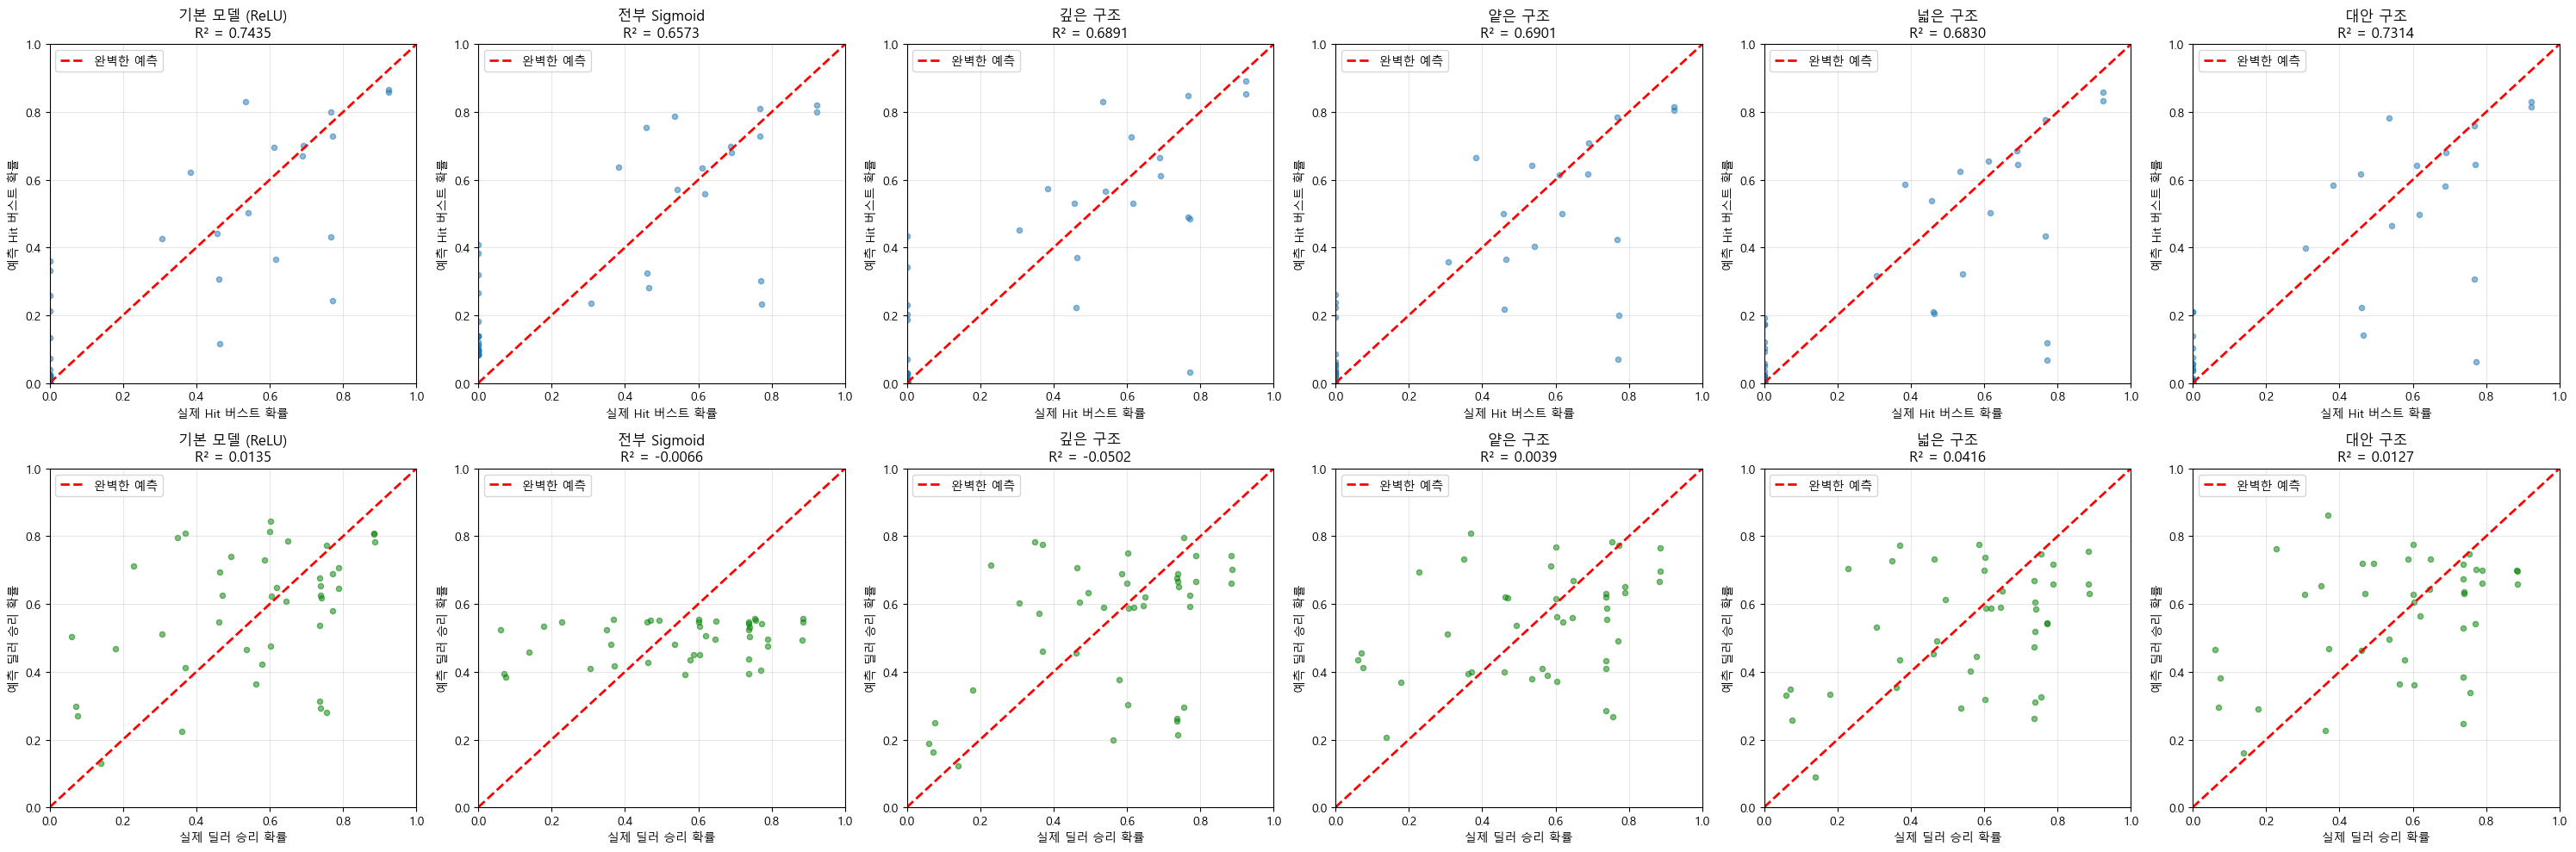

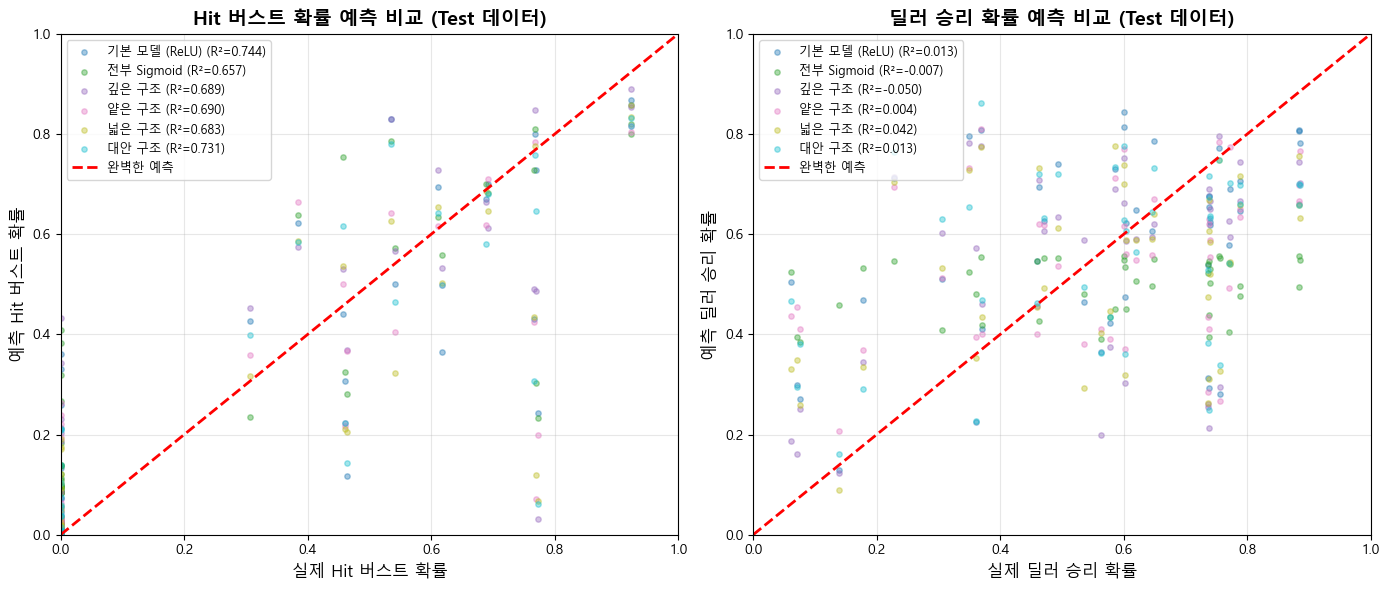


Test 데이터 검증 메트릭 요약 - 회귀 메트릭 (연속형 데이터)
모델명                  Hit R²     Hit RMSE     Hit MAE      Hit 상관     Dealer R²    Dealer RMSE    Dealer MAE     Dealer 상관   
----------------------------------------------------------------------------------------------------
기본 모델 (ReLU)         0.7435     0.166112     0.100977     0.8639     0.0135       0.229458       0.183577       0.4200      
대안 구조                0.7314     0.169977     0.098917     0.8564     0.0127       0.229552       0.181126       0.3826      
넓은 구조                0.6830     0.184667     0.102532     0.8308     0.0416       0.226170       0.183357       0.4108      
얕은 구조                0.6901     0.182588     0.107062     0.8317     0.0039       0.230577       0.186514       0.3387      
전부 Sigmoid           0.6573     0.192012     0.148293     0.8360     -0.0066      0.231781       0.202805       0.2581      
깊은 구조                0.6891     0.182879     0.106919     0.8349     -0.0502      0.236754       0.182604     

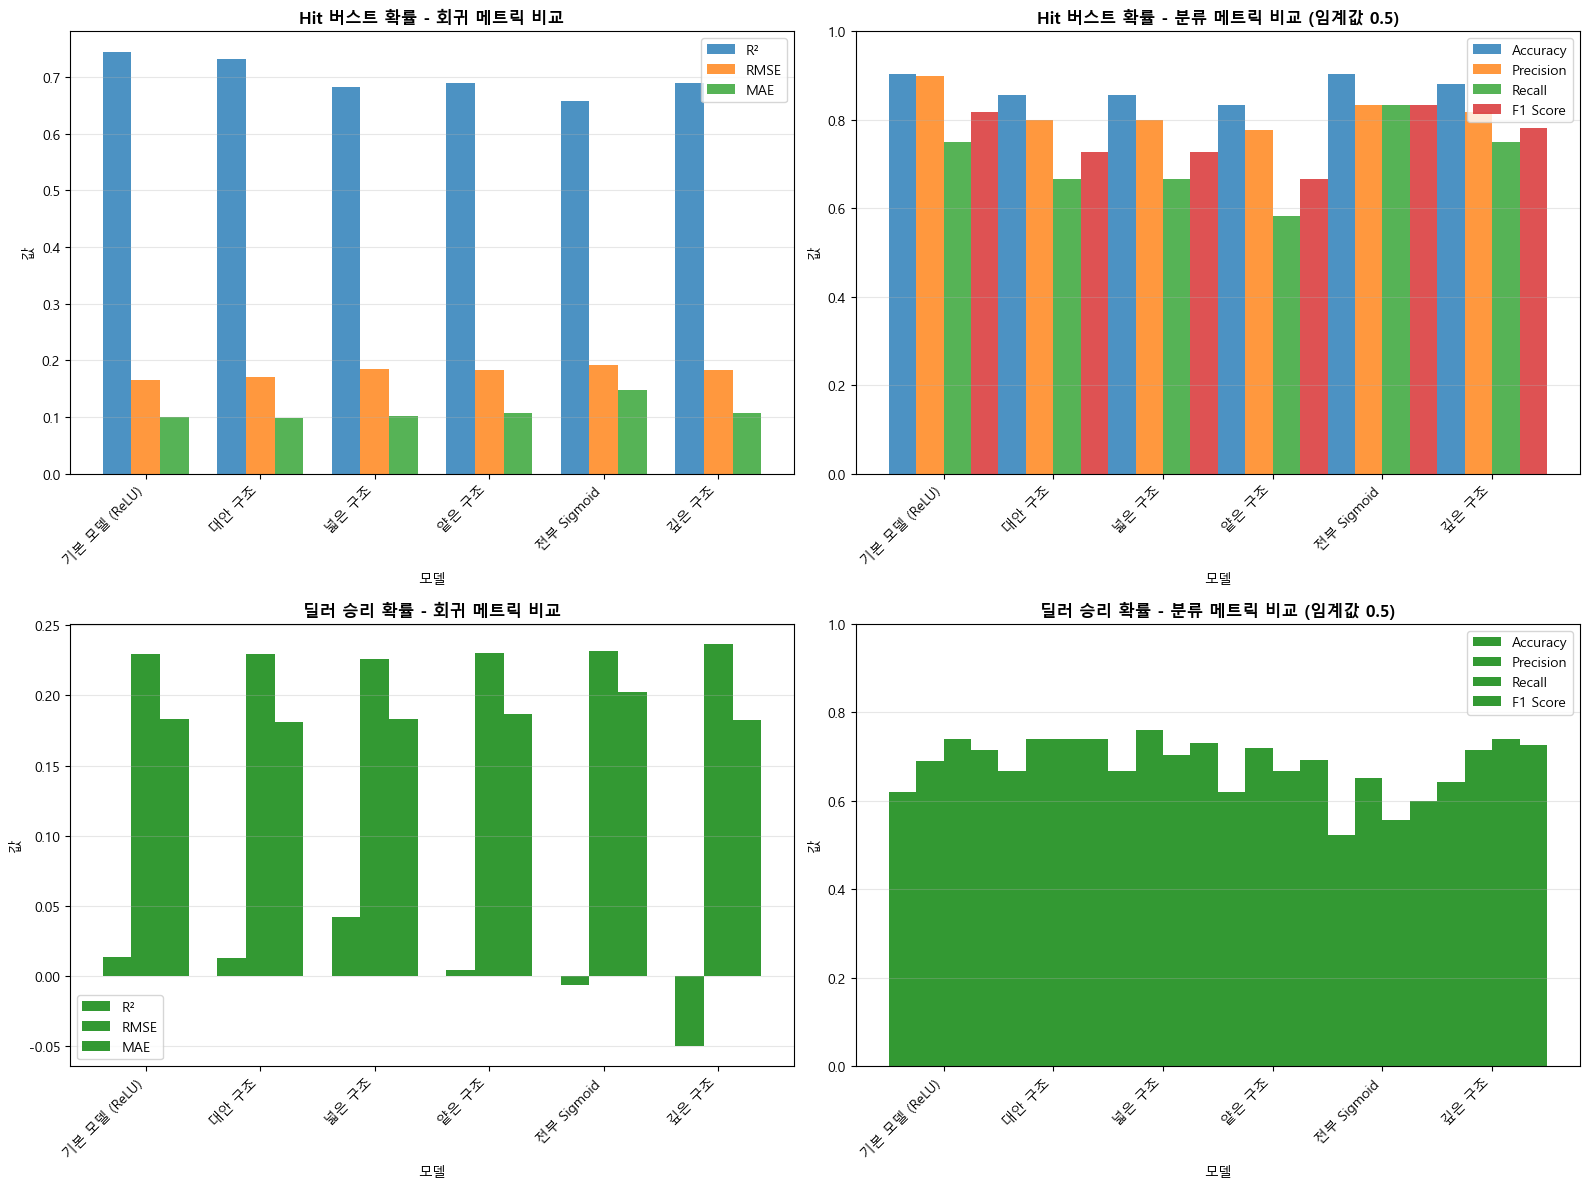


그래프가 저장되었습니다:
  - test_validation_comparison.png: 각 모델별 개별 그래프
  - test_validation_all_models.png: 모든 모델 비교 그래프
  - test_validation_metrics_comparison.png: 메트릭 비교 바 차트


In [14]:
# Test 데이터로 각 모델 검증 및 그래프 시각화

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_percentage_error
)
from scipy.stats import pearsonr

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
try:
    font_list = [f.name for f in fm.fontManager.ttflist]
    if 'Malgun Gothic' not in font_list:
        for font in ['NanumGothic', 'NanumBarunGothic', 'AppleGothic', 'Gulim']:
            if font in font_list:
                plt.rcParams['font.family'] = font
                break
except:
    pass

print("=" * 70)
print("Test 데이터로 각 모델 검증 및 시각화")
print("=" * 70)

# Test 데이터의 실제 값 수집
test_features_list = []
test_labels_list = []

for features, labels in test_loader:
    test_features_list.append(features.cpu().numpy())
    test_labels_list.append(labels.cpu().numpy())

test_features_all = np.concatenate(test_features_list, axis=0)
test_labels_all = np.concatenate(test_labels_list, axis=0)

y_true_hit = test_labels_all[:, 0]
y_true_dealer = test_labels_all[:, 1]

# 각 모델에 대한 예측 수집
model_predictions = {}

for model_key, config in MODEL_CONFIGS.items():
    model_path = f'blackjack_model_probabilities_{model_key}.pth'
    
    if not os.path.exists(model_path):
        print(f"\n경고: {config['name']} 모델 파일을 찾을 수 없습니다. 건너뜁니다.")
        continue
    
    # 모델 로드
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model_config = checkpoint['model_config']
    scaler = checkpoint.get('scaler', None)
    
    # 모델 생성
    model_type = model_config.get('model_type', model_key)
    if model_type in MODEL_CONFIGS:
        model_class = MODEL_CONFIGS[model_type]['class']
        model = model_class(input_size=model_config['input_size']).to(device)
    else:
        model = BlackjackModelBase(input_size=model_config['input_size']).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # 예측 수행
    predictions = []
    with torch.no_grad():
        for features, _ in test_loader:
            features = features.to(device)
            outputs = model(features)
            predictions.append(outputs.cpu().numpy())
    
    y_pred_all = np.concatenate(predictions, axis=0)
    y_pred_hit = y_pred_all[:, 0]
    y_pred_dealer = y_pred_all[:, 1]
    
    # 회귀 메트릭 계산 (연속형 데이터)
    mse_hit = mean_squared_error(y_true_hit, y_pred_hit)
    rmse_hit = np.sqrt(mse_hit)
    mae_hit = mean_absolute_error(y_true_hit, y_pred_hit)
    r2_hit = r2_score(y_true_hit, y_pred_hit)
    
    # MAPE 계산 (0 값 처리)
    mape_hit = np.mean(np.abs((y_true_hit - y_pred_hit) / (y_true_hit + 1e-8))) * 100
    
    # 상관계수 계산
    corr_hit, _ = pearsonr(y_true_hit, y_pred_hit)
    
    mse_dealer = mean_squared_error(y_true_dealer, y_pred_dealer)
    rmse_dealer = np.sqrt(mse_dealer)
    mae_dealer = mean_absolute_error(y_true_dealer, y_pred_dealer)
    r2_dealer = r2_score(y_true_dealer, y_pred_dealer)
    mape_dealer = np.mean(np.abs((y_true_dealer - y_pred_dealer) / (y_true_dealer + 1e-8))) * 100
    corr_dealer, _ = pearsonr(y_true_dealer, y_pred_dealer)
    
    # 분류 메트릭 계산 (임계값 0.5 사용)
    # Hit 버스트 확률: > 0.5면 "위험", <= 0.5면 "안전"
    y_true_hit_binary = (y_true_hit > 0.5).astype(int)
    y_pred_hit_binary = (y_pred_hit > 0.5).astype(int)
    
    accuracy_hit = accuracy_score(y_true_hit_binary, y_pred_hit_binary)
    precision_hit = precision_score(y_true_hit_binary, y_pred_hit_binary, zero_division=0)
    recall_hit = recall_score(y_true_hit_binary, y_pred_hit_binary, zero_division=0)
    f1_hit = f1_score(y_true_hit_binary, y_pred_hit_binary, zero_division=0)
    
    # 딜러 승리 확률: > 0.5면 "딜러 승리 가능", <= 0.5면 "플레이어 유리"
    y_true_dealer_binary = (y_true_dealer > 0.5).astype(int)
    y_pred_dealer_binary = (y_pred_dealer > 0.5).astype(int)
    
    accuracy_dealer = accuracy_score(y_true_dealer_binary, y_pred_dealer_binary)
    precision_dealer = precision_score(y_true_dealer_binary, y_pred_dealer_binary, zero_division=0)
    recall_dealer = recall_score(y_true_dealer_binary, y_pred_dealer_binary, zero_division=0)
    f1_dealer = f1_score(y_true_dealer_binary, y_pred_dealer_binary, zero_division=0)
    
    model_predictions[model_key] = {
        'name': config['name'],
        'y_pred_hit': y_pred_hit,
        'y_pred_dealer': y_pred_dealer,
        # 회귀 메트릭
        'mse_hit': mse_hit,
        'rmse_hit': rmse_hit,
        'mae_hit': mae_hit,
        'mape_hit': mape_hit,
        'r2_hit': r2_hit,
        'corr_hit': corr_hit,
        'mse_dealer': mse_dealer,
        'rmse_dealer': rmse_dealer,
        'mae_dealer': mae_dealer,
        'mape_dealer': mape_dealer,
        'r2_dealer': r2_dealer,
        'corr_dealer': corr_dealer,
        # 분류 메트릭
        'accuracy_hit': accuracy_hit,
        'precision_hit': precision_hit,
        'recall_hit': recall_hit,
        'f1_hit': f1_hit,
        'accuracy_dealer': accuracy_dealer,
        'precision_dealer': precision_dealer,
        'recall_dealer': recall_dealer,
        'f1_dealer': f1_dealer
    }
    
    print(f"\n{config['name']}:")
    print(f"  [Hit 버스트 확률 - 회귀 메트릭]")
    print(f"    MSE: {mse_hit:.6f}, RMSE: {rmse_hit:.6f}, MAE: {mae_hit:.6f}")
    print(f"    MAPE: {mape_hit:.2f}%, R²: {r2_hit:.4f}, 상관계수: {corr_hit:.4f}")
    print(f"  [Hit 버스트 확률 - 분류 메트릭 (임계값 0.5)]")
    print(f"    Accuracy: {accuracy_hit:.4f}, Precision: {precision_hit:.4f}, Recall: {recall_hit:.4f}, F1: {f1_hit:.4f}")
    print(f"  [딜러 승리 확률 - 회귀 메트릭]")
    print(f"    MSE: {mse_dealer:.6f}, RMSE: {rmse_dealer:.6f}, MAE: {mae_dealer:.6f}")
    print(f"    MAPE: {mape_dealer:.2f}%, R²: {r2_dealer:.4f}, 상관계수: {corr_dealer:.4f}")
    print(f"  [딜러 승리 확률 - 분류 메트릭 (임계값 0.5)]")
    print(f"    Accuracy: {accuracy_dealer:.4f}, Precision: {precision_dealer:.4f}, Recall: {recall_dealer:.4f}, F1: {f1_dealer:.4f}")

# 그래프 생성
if len(model_predictions) > 0:
    n_models = len(model_predictions)
    fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))
    
    if n_models == 1:
        axes = axes.reshape(2, 1)
    
    for idx, (model_key, pred_data) in enumerate(model_predictions.items()):
        # Hit 버스트 확률 그래프
        ax1 = axes[0, idx]
        ax1.scatter(y_true_hit, pred_data['y_pred_hit'], alpha=0.5, s=20)
        ax1.plot([0, 1], [0, 1], 'r--', lw=2, label='완벽한 예측')
        ax1.set_xlabel('실제 Hit 버스트 확률')
        ax1.set_ylabel('예측 Hit 버스트 확률')
        ax1.set_title(f"{pred_data['name']}\nR² = {pred_data['r2_hit']:.4f}")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim([0, 1])
        ax1.set_ylim([0, 1])
        
        # 딜러 승리 확률 그래프
        ax2 = axes[1, idx]
        ax2.scatter(y_true_dealer, pred_data['y_pred_dealer'], alpha=0.5, s=20, color='green')
        ax2.plot([0, 1], [0, 1], 'r--', lw=2, label='완벽한 예측')
        ax2.set_xlabel('실제 딜러 승리 확률')
        ax2.set_ylabel('예측 딜러 승리 확률')
        ax2.set_title(f"{pred_data['name']}\nR² = {pred_data['r2_dealer']:.4f}")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim([0, 1])
        ax2.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('test_validation_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 모든 모델 비교 그래프 (하나의 그래프에)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Hit 버스트 확률 비교
    ax1 = axes[0]
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_predictions)))
    for idx, (model_key, pred_data) in enumerate(model_predictions.items()):
        ax1.scatter(y_true_hit, pred_data['y_pred_hit'], 
                   alpha=0.4, s=15, label=f"{pred_data['name']} (R²={pred_data['r2_hit']:.3f})",
                   color=colors[idx])
    ax1.plot([0, 1], [0, 1], 'r--', lw=2, label='완벽한 예측')
    ax1.set_xlabel('실제 Hit 버스트 확률', fontsize=12)
    ax1.set_ylabel('예측 Hit 버스트 확률', fontsize=12)
    ax1.set_title('Hit 버스트 확률 예측 비교 (Test 데이터)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    
    # 딜러 승리 확률 비교
    ax2 = axes[1]
    for idx, (model_key, pred_data) in enumerate(model_predictions.items()):
        ax2.scatter(y_true_dealer, pred_data['y_pred_dealer'], 
                   alpha=0.4, s=15, label=f"{pred_data['name']} (R²={pred_data['r2_dealer']:.3f})",
                   color=colors[idx])
    ax2.plot([0, 1], [0, 1], 'r--', lw=2, label='완벽한 예측')
    ax2.set_xlabel('실제 딜러 승리 확률', fontsize=12)
    ax2.set_ylabel('예측 딜러 승리 확률', fontsize=12)
    ax2.set_title('딜러 승리 확률 예측 비교 (Test 데이터)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('test_validation_all_models.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 메트릭 비교 테이블 - 회귀 메트릭
    print("\n" + "=" * 100)
    print("Test 데이터 검증 메트릭 요약 - 회귀 메트릭 (연속형 데이터)")
    print("=" * 100)
    print(f"{'모델명':<20} {'Hit R²':<10} {'Hit RMSE':<12} {'Hit MAE':<12} {'Hit 상관':<10} {'Dealer R²':<12} {'Dealer RMSE':<14} {'Dealer MAE':<14} {'Dealer 상관':<12}")
    print("-" * 100)
    
    sorted_by_r2 = sorted(model_predictions.items(), 
                         key=lambda x: x[1]['r2_hit'] + x[1]['r2_dealer'], 
                         reverse=True)
    
    for model_key, pred_data in sorted_by_r2:
        print(f"{pred_data['name']:<20} "
              f"{pred_data['r2_hit']:<10.4f} "
              f"{pred_data['rmse_hit']:<12.6f} "
              f"{pred_data['mae_hit']:<12.6f} "
              f"{pred_data['corr_hit']:<10.4f} "
              f"{pred_data['r2_dealer']:<12.4f} "
              f"{pred_data['rmse_dealer']:<14.6f} "
              f"{pred_data['mae_dealer']:<14.6f} "
              f"{pred_data['corr_dealer']:<12.4f}")
    
    # 메트릭 비교 테이블 - 분류 메트릭
    print("\n" + "=" * 100)
    print("Test 데이터 검증 메트릭 요약 - 분류 메트릭 (임계값 0.5 기준)")
    print("=" * 100)
    print(f"{'모델명':<20} {'Hit Acc':<10} {'Hit Prec':<12} {'Hit Rec':<12} {'Hit F1':<10} {'Dealer Acc':<12} {'Dealer Prec':<14} {'Dealer Rec':<14} {'Dealer F1':<12}")
    print("-" * 100)
    
    for model_key, pred_data in sorted_by_r2:
        print(f"{pred_data['name']:<20} "
              f"{pred_data['accuracy_hit']:<10.4f} "
              f"{pred_data['precision_hit']:<12.4f} "
              f"{pred_data['recall_hit']:<12.4f} "
              f"{pred_data['f1_hit']:<10.4f} "
              f"{pred_data['accuracy_dealer']:<12.4f} "
              f"{pred_data['precision_dealer']:<14.4f} "
              f"{pred_data['recall_dealer']:<14.4f} "
              f"{pred_data['f1_dealer']:<12.4f}")
    
    # 메트릭 시각화 - 바 차트
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    model_names = [pred_data['name'] for _, pred_data in sorted_by_r2]
    
    # Hit 버스트 확률 - 회귀 메트릭
    ax1 = axes[0, 0]
    r2_hit_vals = [pred_data['r2_hit'] for _, pred_data in sorted_by_r2]
    rmse_hit_vals = [pred_data['rmse_hit'] for _, pred_data in sorted_by_r2]
    mae_hit_vals = [pred_data['mae_hit'] for _, pred_data in sorted_by_r2]
    
    x = np.arange(len(model_names))
    width = 0.25
    ax1.bar(x - width, r2_hit_vals, width, label='R²', alpha=0.8)
    ax1.bar(x, rmse_hit_vals, width, label='RMSE', alpha=0.8)
    ax1.bar(x + width, mae_hit_vals, width, label='MAE', alpha=0.8)
    ax1.set_xlabel('모델')
    ax1.set_ylabel('값')
    ax1.set_title('Hit 버스트 확률 - 회귀 메트릭 비교', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Hit 버스트 확률 - 분류 메트릭
    ax2 = axes[0, 1]
    acc_hit_vals = [pred_data['accuracy_hit'] for _, pred_data in sorted_by_r2]
    prec_hit_vals = [pred_data['precision_hit'] for _, pred_data in sorted_by_r2]
    rec_hit_vals = [pred_data['recall_hit'] for _, pred_data in sorted_by_r2]
    f1_hit_vals = [pred_data['f1_hit'] for _, pred_data in sorted_by_r2]
    
    ax2.bar(x - width*1.5, acc_hit_vals, width, label='Accuracy', alpha=0.8)
    ax2.bar(x - width*0.5, prec_hit_vals, width, label='Precision', alpha=0.8)
    ax2.bar(x + width*0.5, rec_hit_vals, width, label='Recall', alpha=0.8)
    ax2.bar(x + width*1.5, f1_hit_vals, width, label='F1 Score', alpha=0.8)
    ax2.set_xlabel('모델')
    ax2.set_ylabel('값')
    ax2.set_title('Hit 버스트 확률 - 분류 메트릭 비교 (임계값 0.5)', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim([0, 1])
    
    # 딜러 승리 확률 - 회귀 메트릭
    ax3 = axes[1, 0]
    r2_dealer_vals = [pred_data['r2_dealer'] for _, pred_data in sorted_by_r2]
    rmse_dealer_vals = [pred_data['rmse_dealer'] for _, pred_data in sorted_by_r2]
    mae_dealer_vals = [pred_data['mae_dealer'] for _, pred_data in sorted_by_r2]
    
    ax3.bar(x - width, r2_dealer_vals, width, label='R²', alpha=0.8, color='green')
    ax3.bar(x, rmse_dealer_vals, width, label='RMSE', alpha=0.8, color='green')
    ax3.bar(x + width, mae_dealer_vals, width, label='MAE', alpha=0.8, color='green')
    ax3.set_xlabel('모델')
    ax3.set_ylabel('값')
    ax3.set_title('딜러 승리 확률 - 회귀 메트릭 비교', fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(model_names, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 딜러 승리 확률 - 분류 메트릭
    ax4 = axes[1, 1]
    acc_dealer_vals = [pred_data['accuracy_dealer'] for _, pred_data in sorted_by_r2]
    prec_dealer_vals = [pred_data['precision_dealer'] for _, pred_data in sorted_by_r2]
    rec_dealer_vals = [pred_data['recall_dealer'] for _, pred_data in sorted_by_r2]
    f1_dealer_vals = [pred_data['f1_dealer'] for _, pred_data in sorted_by_r2]
    
    ax4.bar(x - width*1.5, acc_dealer_vals, width, label='Accuracy', alpha=0.8, color='green')
    ax4.bar(x - width*0.5, prec_dealer_vals, width, label='Precision', alpha=0.8, color='green')
    ax4.bar(x + width*0.5, rec_dealer_vals, width, label='Recall', alpha=0.8, color='green')
    ax4.bar(x + width*1.5, f1_dealer_vals, width, label='F1 Score', alpha=0.8, color='green')
    ax4.set_xlabel('모델')
    ax4.set_ylabel('값')
    ax4.set_title('딜러 승리 확률 - 분류 메트릭 비교 (임계값 0.5)', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(model_names, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('test_validation_metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n그래프가 저장되었습니다:")
    print("  - test_validation_comparison.png: 각 모델별 개별 그래프")
    print("  - test_validation_all_models.png: 모든 모델 비교 그래프")
    print("  - test_validation_metrics_comparison.png: 메트릭 비교 바 차트")
else:
    print("\n검증할 모델이 없습니다. 먼저 모델을 학습시켜주세요.")

